# Classificação de Filmes

**Carregamento das bibliotecas numpy, keras, tensorflow**

Verificação do suporte a GPU pela tensorflow

In [1]:
import numpy as np
print("numpy version:", np.__version__)

import keras
print("keras version:", keras.__version__)

import tensorflow as tf
print("tensorflow version:", tf.__version__)

print("GPU support:", tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

numpy version: 1.17.5


Using TensorFlow backend.


keras version: 2.2.5
tensorflow version: 1.15.0
GPU support: True


**Carregamento do dataset IMDB**

Serão preservadas apenas as 10.000 palavras mais frequentes

In [2]:
# A modificação abaixo nao eh necessaria, caso a numpy seja mais recente
# que a versao 1.16.5

# A alteraçao em np.load eh necessaria para evitar uma incompatibilidade 
# entre a keras (>=2.2.4) e a numpy (>=1.16.3). Ela ocorre no arquivo 
# imdb.py da keras que precisa ter np.load(path ,allow_pickle=True). Ateh
# este problema ser corrigido na keras a forma mais pratica eh alterar a 
# funcao np.load, carregar o dataset da keras e retornar a funcao ao seu 
# estado original (vide a seguir).

#old = np.load
#np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

#np.load = old
#del(old)

17465344/17464789 [==============================] - 1s 0us/step


**Formato e estrutura do dataset IMDB**

Cada elemento em train_data é uma lista de palavras codificadas que compõe um comentário sobre um filme. Por exemplo as 10 primeiras palavras da 15a lista seriam:

In [3]:
train_data.shape

(25000,)

In [4]:
print(train_data[14][:10])

[1, 503, 20, 33, 118, 481, 302, 26, 184, 52]


Cada elemento em train_labels é a classificação dada ao comentário (0 negativo), (1 positivo). Por exemplo o comentário de índice 78 foi classificado como negativo

In [5]:
print(train_labels[78])

0


**Recuperação do texto a partir da codificação das palavras**

Para reverter a sequência de números a um texto podemos lançar mão do dicionário "word_index". Primeiro carregamos o dicionário.

In [6]:
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 1s 0us/step


Em seguida imprimimos parte do mesmo para entender a formatação dos dados. 
Observe que a palavra 'fawn' foi codificada no dicionário pelo número 34701

In [7]:
list(word_index.items())[:5]

[('fawn', 34701),
 ('tsukino', 52006),
 ('nunnery', 52007),
 ('sonja', 16816),
 ('vani', 63951)]

Vamos criar um novo dicionário de nome index_word, trocando as chaves (*keys*) e os valores (*values*) entre si.

In [8]:
index_word = dict([(valor, chave) for chave, valor in word_index.items()])
list(index_word.items())[:5]

[(34701, 'fawn'),
 (52006, 'tsukino'),
 (52007, 'nunnery'),
 (16816, 'sonja'),
 (63951, 'vani')]

Uma vez criado o dicionário utilizamos o mesmo para "decodificar" um comentário. Observe no entanto que a codificação no dataset imdb esta deslocada de 3. Sendo assim a palavra que em train_data foi codificada como 4, no dicionário aparece como 1. Por isso o uso de i-3 ao recuperar o valor no dicionário a partir da sua chave.

In [9]:
decoded_review = ' '.join([index_word.get(i - 3, '?') for i in train_data[0]])
print(decoded_review[:100])

? this film was just brilliant casting location scenery story direction everyone's really suited the


**Dummificação dos valores de entrada**

Para passar os dados à rede neural precisamos dummificar os valores de entrada. 

Como temos 10.000 valores diferentes possíveis (um para cada palavra) temos de criar uma matriz com 25.000 linhas (uma para cada comentário) e 10.000 colunas (uma para cada palavra). 

As palavras presentes em um comentário seriam indicadas por 1 na sua coluna respectiva na matriz. Observe porém que neste método perde-se a sequência das palavras. Nesta etapa vamos preservar apenas as palavras em si, em cada comentário.

In [0]:
import numpy as np
def vectorize_sequences(sequencia, colunas=10000):
    resultado = np.zeros((len(sequencia), colunas))
    for indice, valor in enumerate(sequencia):
        resultado[indice, valor] = 1.
    return resultado

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [11]:
x_train[0:4]

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [13]:
x_train.shape

(25000, 10000)

No caso dos labels, dado que eles são compostos apenas de 0s e 1s a vetorização é quase direta

In [0]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [15]:
y_train[0:4]

array([1., 0., 0., 1.], dtype=float32)

In [17]:
y_train.shape

(25000,)

**Definição da Estrutura da Rede Neural**

In [18]:
from keras import models
model = models.Sequential()

from keras import layers
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense( 1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#ou de forma equivalente passando funcoes como argumentos
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

from keras import losses
model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss=losses.binary_crossentropy, metrics=['accuracy'])

from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


De forma resumida a estrutura da rede neural pode ser montada com os seguintes comandos:

In [0]:
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense( 1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

**Treino da Rede Neural**

Para acompanhar o treino criamos também um conjunto de dados de *pré teste* isto é separamos do conjunto de treino um grupo de dados para validação.

In [0]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

 O treino será executado no grupo partial_x_train em 20 épocas (passagens por todo o grupo de treino, neste caso partial_x_train). Cada época terá seus dados agrupados em mini batches de 512 amostras. A validação ocorrerá no conjunto de validação (x_val). A passagem dos parâmetros pode ser vista de forma completa a seguir:

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))




Train on 15000 samples, validate on 10000 samples
Epoch 1/20





15000/15000 [==============================] - 9s 617us/step - loss: 0.5054 - binary_accuracy: 0.7916 - val_loss: 0.3906 - val_binary_accuracy: 0.8530
Epoch 2/20
15000/15000 [==============================] - 1s 71us/step - loss: 0.2954 - binary_accuracy: 0.9063 - val_loss: 0.3418 - val_binary_accuracy: 0.8616
Epoch 3/20
15000/15000 [==============================] - 1s 73us/step - loss: 0.2189 - binary_accuracy: 0.9297 - val_loss: 0.2830 - val_binary_accuracy: 0.8882
Epoch 4/20
15000/15000 [==============================] - 1s 71us/step - loss: 0.1719 - binary_accuracy: 0.9469 - val_loss: 0.2791 - val_binary_accuracy: 0.8870
Epoch 5/20
15000/15000 [==============================] - 1s 71us/step - loss: 0.1366 - binary_accuracy: 0.9584 - val_loss: 0.2807 - val_binary_accuracy: 0.8878
Epoch 6/20
15000/15000 [==============================] - 1s 72us/step - loss: 0.1138 - binary_accuracy: 0.9644 - val_loss: 0.3313 - val

O retorno do método .fit é um objeto do tipo History, o qual neste caso foi denominado *history_dict*. Ele possui um dicionário que pode ser acessado através da propriedade *.history*

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

Com as informações armazenadas neste dicionário pode-se traçar um gráfico da evolução do erro e da precisão durante o treino.

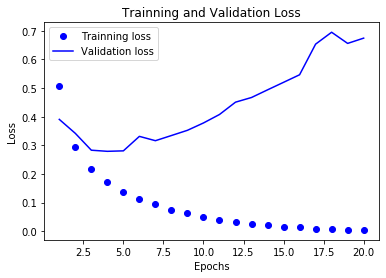

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss'])+1)

plt.title('Trainning and Validation Loss')
plt.plot(epochs, loss_values, 'bo', label='Trainning loss') #'bo' é um ponto azul (blue dot)
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') #'b' é uma linha azul contínua
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

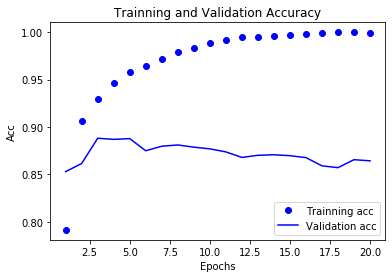

In [28]:
plt.clf() # Para limpar o gráfico anterior da memória

acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

epochs = range(1, len(history_dict['binary_accuracy'])+1)

plt.title('Trainning and Validation Accuracy')
plt.plot(epochs, acc_values, 'bo', label='Trainning acc') #'bo' é um ponto azul (blue dot)
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') #'b' é uma linha azul contínua
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

Evitando o overfitting

Uma forma imediata (porém muito simplista) de evitar o overfitting seria treinando a rede em apenas 3 épocas. O que é apresentado a seguir

In [29]:
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense( 1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=512)

print('teste')
results = model.evaluate(x_test, y_test)
results

Epoch 1/3
25000/25000 [==============================] - 1s 53us/step - loss: 0.4605 - acc: 0.8298
Epoch 2/3
25000/25000 [==============================] - 1s 47us/step - loss: 0.2653 - acc: 0.9076
Epoch 3/3
25000/25000 [==============================] - 1s 49us/step - loss: 0.2019 - acc: 0.9292
teste
25000/25000 [==============================] - 2s 85us/step


[0.28491373341560366, 0.8866]

**Exercícios**

*   Faça os exercícios a seguir tomando por base uma rede neural:
      * Sequencial
      * Que irá receber um tensor de entrada 1D, com formato (10000,)
      * Com duas camadas intermediárias do tipo denso, cada uma com 16 neurons com função de ativação `relu`
      * Uma camada de saida com 1 neuron com função de ativação `sigmoid`
      * Otimizador: 'rmsprop' 
      * Função de erro: 'binary_crossentropy'
      * Métrica de desempenho: 'accuracy'

1.  Determine de forma gráfica a quantidade de épocas de treino necessárias para que o erro no conjunto de validação seja aproximadamente igual ao erro no conjunto de treino e determine o valor correspondente do mesmo para as seguintes redes neurais.
      1. A rede neural descrita acima. A partir dela alterar os parâmetros a seguir (sempre em relação à rede neural descrita acima).
      2. Uma rede neural com apenas uma camada intermediária de 16 neurons
      3. Uma rede neural com três camadas intermediárias de 16 neurons
      4. Uma rede neural com três camadas intermediárias de 32 neurons
      5. Uma rede neural com três camadas intermediárias de 64 neurons
      6. Uma rede neural com três camadas intermediárias de 16 neurons e função de erro mean squared erro
      7. Uma rede neural com três camadas intermediárias de 16 neurons e função de ativação `tanh`.      
      8. Uma rede neural com três camadas intermediárias de 16, 32 e 16 neurons.
      9. Uma rede neural com três camadas intermediárias de 16, 32 e 64 neurons. 
